In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Initiliaze working directories

# Change this to input folder
# Will look for all .MOV files, with code in the next section
KAGGLE_DATA_PATH = '/kaggle/input/include/Adjectives_1of8'

WORKING_DIR = '/kaggle/working/'
LANDMARKS_DIR = os.path.join(WORKING_DIR, 'extracted_landmarks')

# Use if cropping with Yolo
CROPPED_FRAMES_DIR = os.path.join(WORKING_DIR, 'yolo_cropped_frames')

os.makedirs(CROPPED_FRAMES_DIR, exist_ok=True)
os.makedirs(LANDMARKS_DIR, exist_ok=True)

# Create if not existant
print(f"Kaggle Data Path: {KAGGLE_DATA_PATH}")
print(f"Working Directory: {WORKING_DIR}")

model_name = "CNN_LSTM_v1"

Kaggle Data Path: /kaggle/input/include/Adjectives_1of8
Working Directory: /kaggle/working/


In [3]:
# Load all files relating to the input

file_paths = []

# This loop currently works for the INCLUDE Dataset
# Change this to make it fit your own dataset
for root, dirs, files in os.walk(KAGGLE_DATA_PATH):
    for file in files:
        if file.endswith('.MOV'):
            file_path = os.path.join(root, file)
            path_components = file_path.split('/')    
            for component in reversed(path_components):
                if '. ' in component:
                 word = component.split('. ')[1]
            file_paths.append([word.lower(), file_path])

In [4]:
# Additional/Private Dataset

KAGGLE_DATA_PATH_PRIVATE = "/kaggle/input/include-private/Adjectives_1of8"

for root, dirs, files in os.walk(KAGGLE_DATA_PATH_PRIVATE):
    for file in files:
        if file.endswith('.mp4'):
            file_path = os.path.join(root, file)
            path_components = file_path.split('/')    
            for component in reversed(path_components):
                if '. ' in component:
                 word = component.split('. ')[1]
            file_paths.append([word.lower(), file_path])

In [5]:
# Creates an array in the form of ['word', 'file path']
file_paths = np.array(file_paths)
file_paths.shape

(144, 2)

In [8]:
# Function to extract landmarks using MediaPipe Holistic Model
!pip install mediapipe
import mediapipe as mp

mp_holistic = mp.solutions.holistic

def extract_landmarks(frame, holistic_model, frame_number=None):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic_model.process(rgb_frame)

    POSE_LANDMARKS = 33
    FACE_LANDMARKS = 468
    HAND_LANDMARKS = 21
    TOTAL_LANDMARKS = POSE_LANDMARKS + FACE_LANDMARKS + HAND_LANDMARKS + HAND_LANDMARKS

    frame_landmarks = np.zeros((TOTAL_LANDMARKS, 4))

    def get_landmarks_data(landmarks_obj, num_landmarks, include_visibility=False):
        if landmarks_obj:
            coords = np.array([[lmk.x, lmk.y, lmk.z] for lmk in landmarks_obj.landmark])
            if include_visibility:
                visibility = np.array([[lmk.visibility] for lmk in landmarks_obj.landmark])
                return np.hstack([coords, visibility])
            else:
                return np.hstack([coords, np.zeros((coords.shape[0], 1))])
        return np.zeros((num_landmarks, 4))

    start_idx = 0
    
    pose_data = get_landmarks_data(results.pose_landmarks, POSE_LANDMARKS, include_visibility=True)
    frame_landmarks[start_idx : start_idx + POSE_LANDMARKS] = pose_data
    start_idx += POSE_LANDMARKS

    face_data = get_landmarks_data(results.face_landmarks, FACE_LANDMARKS)
    frame_landmarks[start_idx : start_idx + FACE_LANDMARKS] = face_data
    start_idx += FACE_LANDMARKS

    left_hand_data = get_landmarks_data(results.left_hand_landmarks, HAND_LANDMARKS)
    frame_landmarks[start_idx : start_idx + HAND_LANDMARKS] = left_hand_data
    start_idx += HAND_LANDMARKS

    right_hand_data = get_landmarks_data(results.right_hand_landmarks, HAND_LANDMARKS)
    frame_landmarks[start_idx : start_idx + HAND_LANDMARKS] = right_hand_data

    return frame_landmarks

# Function to loop through frames and create single np.array of features in shape of (number of videos, frames processed, features per frame)
# Saves the landmarks, and labels to a file in the working directory 
def process_videos(file_paths_array, sequence_length=60):
    holistic_model = mp_holistic.Holistic(
        static_image_mode=False,
        model_complexity=2,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )

    video_landmarks = []
    labels = []

    for i, (word, file_path) in enumerate(file_paths_array):
        print(f"Processing video {i+1}/{len(file_paths_array)}: {file_path} (Label: {word})")
        
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file {file_path}. Skipping.")
            continue

        current_video_landmarks = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            landmarks_frame = extract_landmarks(frame, holistic_model, frame_count)
            current_video_landmarks.append(landmarks_frame)
            frame_count += 1
        cap.release()

        if not current_video_landmarks:
            print(f"Warning: No landmarks extracted from {file_path}. Skipping.")
            continue

        video_sequence_array = np.array(current_video_landmarks)

        if video_sequence_array.shape[0] < sequence_length:
            padding_needed = sequence_length - video_sequence_array.shape[0]
            padded_sequence = np.pad(video_sequence_array, ((0, padding_needed), (0, 0), (0, 0)), mode='constant', constant_values=0)
            video_landmarks.append(padded_sequence)
        else:
            truncated_sequence = video_sequence_array[:sequence_length, :, :]
            video_landmarks.append(truncated_sequence)
        
        labels.append(word)

    holistic_model.close()

    if not video_landmarks:
        print("Error: Landmark extraction failed for all videos. Exiting.")
        return

    X_data = np.array(video_landmarks)
    y_data = np.array(labels)

    np.save(os.path.join(LANDMARKS_DIR, 'sequences.npy'), X_data)
    np.save(os.path.join(LANDMARKS_DIR, 'labels.npy'), y_data)

    print(f"\nSuccessfully processed and saved {X_data.shape[0]} sequences.")
    print(f"Shape of landmark sequences (X): {X_data.shape}")
    print(f"Shape of labels (y): {y_data.shape}")

    holistic_model.close()

In [9]:
process_videos(file_paths)

Processing video 1/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9290.MOV (Label: loud)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751537754.496785     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751537754.755186     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751537754.762247     112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751537754.765129     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751537754.765153     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751537754.812058     

Processing video 2/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5258.MOV (Label: loud)
Processing video 3/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9536.MOV (Label: loud)
Processing video 4/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5257.MOV (Label: loud)
Processing video 5/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5177.MOV (Label: loud)
Processing video 6/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5259.MOV (Label: loud)
Processing video 7/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9535.MOV (Label: loud)
Processing video 8/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9449.MOV (Label: loud)
Processing video 9/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9450.MOV (Label: loud)
Processing video 10/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5179.MOV (Label: loud)
Processing video 11/144: /k

ValueError: Closing SolutionBase._graph which is already None

In [10]:
# Load the landmarks from working directory

X = np.load(os.path.join(LANDMARKS_DIR, 'sequences.npy'))
y = np.load(os.path.join(LANDMARKS_DIR, 'labels.npy'))

In [3]:
# Load the landmarks from an uploaded file

X = np.load("/kaggle/input/premade/sequences.npy")
y = np.load("/kaggle/input/premade/labels.npy")

In [ ]:
# Check if loaded correctly
print("Landmarks preview: \n", X[0])
print("Landmarks array shape: \n", X.shape)
print("Labels array shape: \n", y.shape)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder on the labels and transform them
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now, y_train_encoded and y_test_encoded should be arrays of integers
categories = label_encoder.classes_

# Print the categories
print("Encoded Categories:")
print(categories)

Encoded Categories:
['beautiful' 'blind' 'deaf' 'happy' 'loud' 'quiet' 'sad' 'ugly']


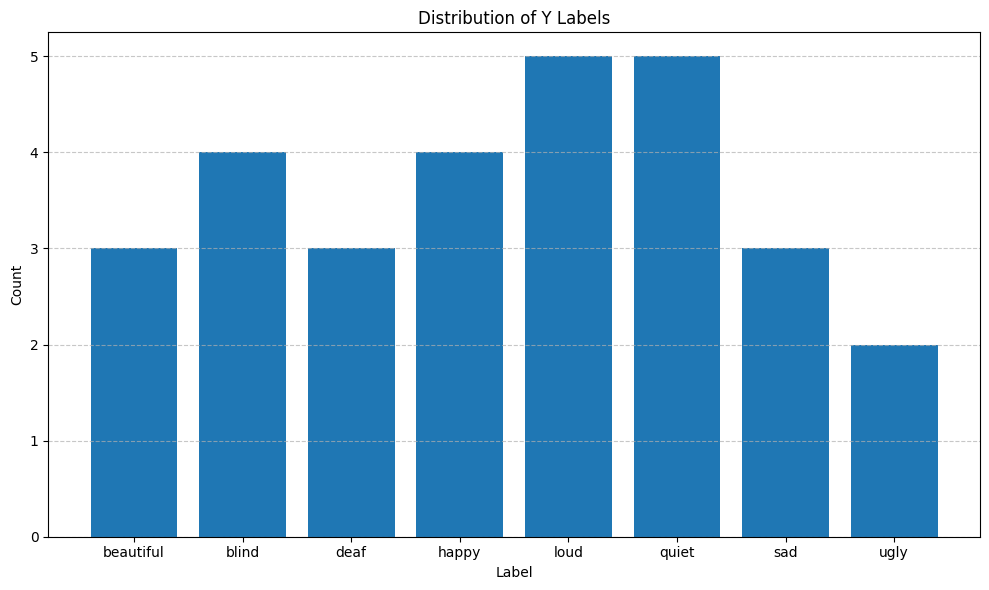

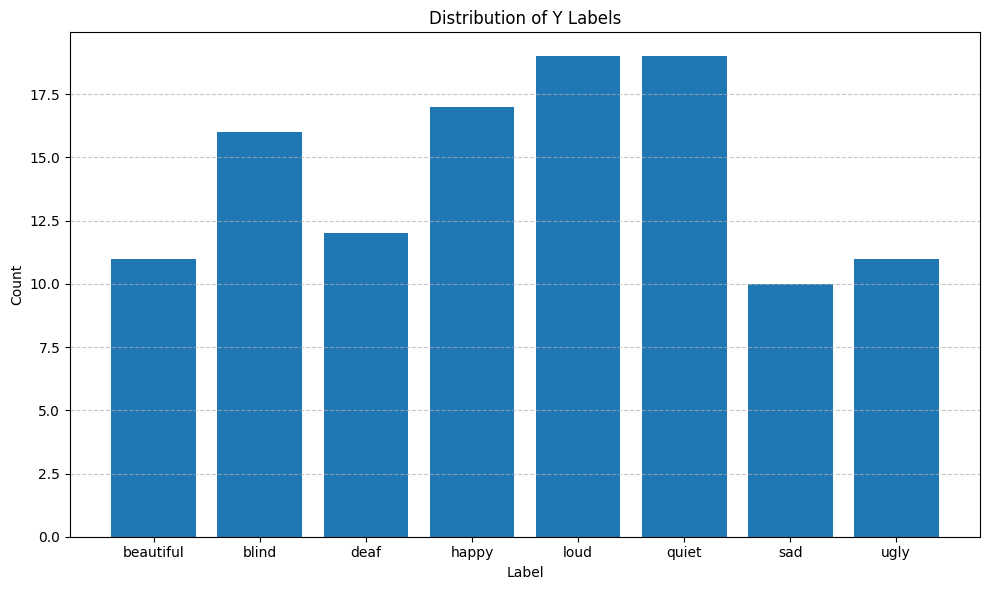

In [5]:
# See the distribution of test, and training data

unique_labels, counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.title('Distribution of Y Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

unique_labels, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.title('Distribution of Y Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Augument to data to increase dataset size

def add_noise(sequence, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=sequence.shape)
    return sequence + noise

def scale_sequence(sequence, scale_range=(0.8, 1.2)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return sequence * scale_factor

def random_crop_sequence(sequence, desired_length=60):
    current_length = sequence.shape[0]
    if current_length > desired_length:
        start_frame = np.random.randint(0, current_length - desired_length)
        return sequence[start_frame:start_frame + desired_length]
    elif current_length < desired_length:
        padding_needed = desired_length - current_length
        last_frame = np.expand_dims(sequence[-1], axis=0)
        padding = np.repeat(last_frame, padding_needed, axis=0)
        return np.vstack([sequence, padding])
    else:
        return sequence

def flip_landmarks(sequence, original_landmark_dim=1662):
    flipped_sequence = sequence.copy()
    
    for frame in flipped_sequence:
        x_indices = np.arange(0, original_landmark_dim, 3)
        frame[x_indices] = -frame[x_indices]
    
    return flipped_sequence

def augment_dataset(X, y, num_augmentations_per_sample=3):
    augmented_X = []
    augmented_y = []
    
    total_original_samples = len(X)
    
    for i in range(total_original_samples):
        original_sequence = X[i]
        original_label = y[i]
        
        augmented_X.append(original_sequence)
        augmented_y.append(original_label)
        
        for _ in range(num_augmentations_per_sample):
            augmented_sequence = original_sequence.copy()
            
            if random.random() < 0.7:
                augmented_sequence = add_noise(augmented_sequence, noise_level=0.005)
            
            if random.random() < 0.5:
                augmented_sequence = scale_sequence(augmented_sequence, scale_range=(0.9, 1.1))
            
            if random.random() < 0.5:
                augmented_sequence = random_crop_sequence(augmented_sequence, desired_length=60)
                
            if random.random() < 0.5:
                augmented_sequence = flip_landmarks(augmented_sequence, original_landmark_dim=1662)

            augmented_X.append(augmented_sequence)
            augmented_y.append(original_label)
            
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)
    
    shuffled_indices = np.arange(len(augmented_X))
    np.random.shuffle(shuffled_indices)
    augmented_X = augmented_X[shuffled_indices]
    augmented_y = augmented_y[shuffled_indices]
    
    return augmented_X, augmented_y

x_train_augmented, y_train_augmented = augment_dataset(x_train, y_train_encoded, num_augmentations_per_sample=5)

print(f"Original training data shape: {x_train.shape}")
print(f"Original training labels shape: {y_train.shape}")
print("-" * 30)
print(f"Augmented training data shape: {x_train_augmented.shape}")
print(f"Augmented training labels shape: {y_train_augmented.shape}")

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, InputLayer, Bidirectional, Reshape, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

num_classes = len(np.unique(y_train_encoded))

2025-07-03 10:46:11.515179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751539571.973450      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751539572.095732      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
model = Sequential()
model.add(InputLayer(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5)) 
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dropout(0.4))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1751539589.232764      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751539589.233502      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 60, 541, 64)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 60, 270, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 60, 268, 128)        │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 60, 134, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 60, 17152)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 60, 512)             │      35,653,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 128)             │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 60, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,205,192 (138.11 MB)

 Trainable params: 36,205,192 (138.11 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(x_train, y_train_encoded, validation_data=(x_test, y_test_encoded), epochs=300, batch_size=4, shuffle=True)

loss, accuracy = model.evaluate(x_test, y_test_encoded)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/300


I0000 00:00:1751539630.112586     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


29/29 ━━━━━━━━━━━━━━━━━━━━ 52s 479ms/step - accuracy: 0.1677 - loss: 2.0970 - val_accuracy: 0.1724 - val_loss: 2.0677
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.1356 - loss: 2.0608 - val_accuracy: 0.1724 - val_loss: 2.0620
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.1886 - loss: 2.0673 - val_accuracy: 0.1724 - val_loss: 2.0647
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.1210 - loss: 2.0883 - val_accuracy: 0.1724 - val_loss: 2.0623
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.1375 - loss: 2.0816 - val_accuracy: 0.1724 - val_loss: 2.0611
Epoch 6/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.1323 - loss: 2.0640 - val_accuracy: 0.1724 - val_loss: 2.0584
Epoch 7/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.2092 - loss: 2.0276 - val_accuracy: 0.2069 - val_loss: 2.0598
Epoch 8/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.1475 - loss: 2.0561 - val_accuracy: 0.172

KeyboardInterrupt: 

In [ ]:
history_dict = history.history
print("Keys in the history dictionary:", history_dict.keys())

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')

print("Loss and accuracy plots have been saved as 'loss_plot.png' and 'accuracy_plot.png'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


<Figure size 1000x800 with 0 Axes>

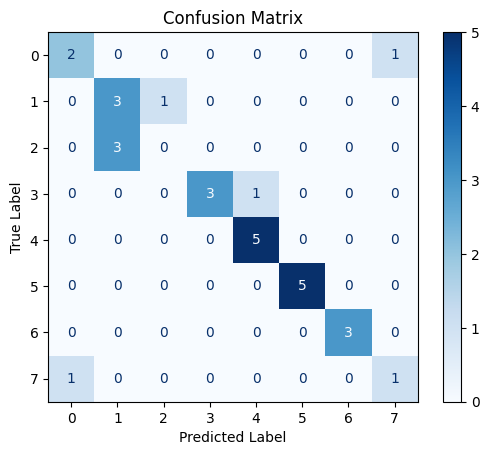

Confusion matrix plot has been saved as 'confusion_matrix.png'.


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(x_test)

# Convert the model's one-hot encoded predictions to integer labels.
y_pred_classes = np.argmax(y_pred, axis=1)

# y_test_encoded is already a 1D array of integer labels, so use it directly.
y_true_classes = y_test_encoded

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

class_labels = None # Or provide your list of class names

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

print("Confusion matrix plot has been saved as 'confusion_matrix.png'.")

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    hp_kernel_size = hp.Int('conv1d_kernel_size', min_value=3, max_value=9, step=1)
    
    hp_filters = hp.Int('conv1d_filters', min_value=32, max_value=128, step=32)
    
    hp_pool_size = hp.Int('maxpool1d_pool_size', min_value=2, max_value=4, step=1)
    
    hp_lstm1_units = hp.Int('lstm1_units', min_value=64, max_value=256, step=64)
    hp_lstm2_units = hp.Int('lstm2_units', min_value=32, max_value=128, step=32)

    hp_dropout1_rate = hp.Float('dropout1_rate', min_value=0.2, max_value=0.6, step=0.1)
    hp_dropout2_rate = hp.Float('dropout2_rate', min_value=0.2, max_value=0.5, step=0.1)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # --- Model Architecture ---
    model.add(TimeDistributed(Reshape((x_train.shape[2], 1)), input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(TimeDistributed(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=hp_pool_size)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(hp_lstm1_units, return_sequences=True))
    model.add(Dropout(hp_dropout1_rate))
    model.add(LSTM(hp_lstm2_units))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(hp_dropout2_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,          # The model-building function
    objective='val_accuracy', # The metric to optimize (maximize validation accuracy)
    max_epochs=50,        # Max epochs for each trial
    factor=3,             # Hyperband reduction factor
    hyperband_iterations=5, # Number of times to run the hyperband algorithm
    directory='my_dir',   # Directory to store the search results
    project_name='cnn_lstm_hyperband_tuning'
)

print("Starting the hyper parameter search...")
tuner.search(x_train, y_train_encoded,
                 epochs=100,
                 validation_data=(x_test, y_test_encoded),
                 batch_size=4)

print("Hyperparameter search is complete!")

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters found are:
- Conv1D Kernel Size: {best_hps.get('conv1d_kernel_size')}
- Conv1D Filters: {best_hps.get('conv1d_filters')}
- MaxPooling1D Pool Size: {best_hps.get('maxpool1d_pool_size')}
- LSTM 1 Units: {best_hps.get('lstm1_units')}
- LSTM 2 Units: {best_hps.get('lstm2_units')}
- Dropout 1 Rate: {best_hps.get('dropout1_rate')}
- Dropout 2 Rate: {best_hps.get('dropout2_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model for a longer period
print("Training the best model on the full dataset...")
history = best_model.fit(x_train_augmented, y_train_augmented,
                          validation_data=(x_test, y_test_encoded),
                          epochs=300, # Use more epochs for the final training
                          batch_size=2)

# Evaluate the final model
loss, accuracy = best_model.evaluate(x_test, y_test_encoded)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

# You can also save the final model
best_model.save('best_cnn_lstm_model.h5')

In [10]:
# Save the model on disk
model.save(f"{model_name}.h5")
model.save(f"{model_name}.keras")
model.export(f"{model_name}")

Saved artifact at 'CNN_LSTM_v1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 543, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136329386137680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386138448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386138640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386137872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386143248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386142672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386145168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386143056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386145552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329386145744: Ten

In [ ]:
import zipfile
zip = zipfile.ZipFile(f"{model_name}.zip", "w", zipfile.ZIP_DEFLATED)
zip.write(f"/kaggle/working/{model_name}.h5")
zip.close()

In [ ]:
# Uploading to google drive if file is too big for kaggle direct download
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Upload the files
uploaded = drive.CreateFile({'title': f"{model_name}_best.zip", 'mimeType': 'application/zip'})
uploaded.SetContentFile(f"/kaggle/working/{model_name}.h5")
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir model_json_2

In [ ]:
!pip install --upgrade tensorflow tensorflowjs

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='MobilenetV1/Predictions/Reshape_1' \
    --saved_model_tags=serve \
    --skip_op_check \
    /kaggle/working/CNN_LSTM_v1 \
    /kaggle/working/model_json_2